In [1]:
import pandas
import numpy
import matplotlib.pyplot

import os
import keras
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
#from keras.layers import SimpleRNN, LSTM
from keras.layers import Conv2D, MaxPool2D
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

ImageSize = (256, 256)
ColorDepth = 3 # RGB

DataFiles_PathRoot = "A:\\Files\\Data\\widsdatathon2019\\"

TrainFiles_Path = DataFiles_PathRoot + "train_images\\"

ValidationFiles_Path = DataFiles_PathRoot + "leaderboard_test_data\\"

#TestFiles_Path = DataFiles_PathRoot + "test\\"
TestFiles_Path = DataFiles_PathRoot + "leaderboard_holdout_data\\"

TrainingData = pandas.read_csv(DataFiles_PathRoot + "traininglabels.csv")
ValidationData = pandas.read_csv(DataFiles_PathRoot + "testlabels.csv")
TestData = pandas.read_csv(DataFiles_PathRoot + "holdout.csv")

Using TensorFlow backend.


In [2]:
TrainingData.info(), display(TrainingData.head()), TrainingData.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15244 entries, 0 to 15243
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image_id     15244 non-null  object 
 1   has_oilpalm  15244 non-null  int64  
 2   score        15244 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 357.4+ KB


,image_id,has_oilpalm,score
0,img_000002017.jpg,0,0.7895
1,img_000012017.jpg,0,1.0000
2,img_000022017.jpg,0,1.0000
3,img_000072017.jpg,0,1.0000
4,img_000082017.jpg,0,1.0000


(None,
 None,
         has_oilpalm         score
 count  15244.000000  15244.000000
 mean       0.061795      0.955769
 std        0.240790      0.109367
 min        0.000000      0.388700
 25%        0.000000      1.000000
 50%        0.000000      1.000000
 75%        0.000000      1.000000
 max        1.000000      1.000000)

In [3]:
ValidationData.info(), display(ValidationData.head()), ValidationData.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4356 entries, 0 to 4355
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image_id     4356 non-null   object 
 1   has_oilpalm  4356 non-null   int64  
 2   score        4356 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 102.2+ KB


,image_id,has_oilpalm,score
0,img_049252017.jpg,0,1.0
1,img_048172017.jpg,1,1.0
2,img_103582017.jpg,0,1.0
3,img_067292017.jpg,0,0.6
4,img_090082017.jpg,0,1.0


(None,
 None,
        has_oilpalm        score
 count   4356.00000  4356.000000
 mean       0.06359     0.953523
 std        0.24405     0.111545
 min        0.00000     0.397800
 25%        0.00000     1.000000
 50%        0.00000     1.000000
 75%        0.00000     1.000000
 max        1.00000     1.000000)

In [4]:
TestData.info(), display(TestData.head()), TestData.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2178 entries, 0 to 2177
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image_id     2178 non-null   object 
 1   has_oilpalm  2178 non-null   int64  
 2   score        2178 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 51.2+ KB


,image_id,has_oilpalm,score
0,img_050982017.jpg,1,1.0000
1,img_101882017.jpg,1,1.0000
2,img_109452017.jpg,1,0.8079
3,img_009842017.jpg,1,1.0000
4,img_083672017.jpg,1,1.0000


(None,
 None,
        has_oilpalm        score
 count  2178.000000  2178.000000
 mean      0.500000     0.947272
 std       0.500115     0.120227
 min       0.000000     0.398300
 25%       0.000000     1.000000
 50%       0.500000     1.000000
 75%       1.000000     1.000000
 max       1.000000     1.000000)

# Data Processing

### Drop data with low confidence scores

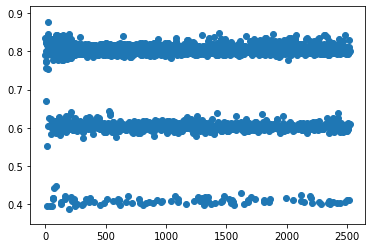

In [5]:
matplotlib.pyplot.close("all")
matplotlib.pyplot.scatter(range(len(TrainingData[TrainingData["score"] < 1])), TrainingData[TrainingData["score"] < 1]["score"])

In [6]:
len(TrainingData[TrainingData["score"] < 0.7])

804

In [7]:
TrainingData = TrainingData[TrainingData["score"] > 0.7]
TrainingData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14440 entries, 0 to 15243
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image_id     14440 non-null  object 
 1   has_oilpalm  14440 non-null  int64  
 2   score        14440 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 451.2+ KB


In [21]:
def SortFolders():
    categories = TrainingData["has_oilpalm"].unique()
    
    for category in categories:
        if not os.path.exists(TrainFiles_Path + str(category)):
            os.mkdir(TrainFiles_Path + str(category))

        if not os.path.exists(ValidationFiles_Path + str(category)):
            os.mkdir(ValidationFiles_Path + str(category))

        if not os.path.exists(TestFiles_Path + str(category)):
            os.mkdir(TestFiles_Path + str(category))

    for rowIndex, rowData in TrainingData.iterrows():
        try:
            os.rename(TrainFiles_Path + rowData["image_id"], TrainFiles_Path + str(rowData["has_oilpalm"]) + "\\" + rowData["image_id"])
        except FileNotFoundError:
            continue

    for rowIndex, rowData in ValidationData.iterrows():
        try:
            os.rename(ValidationFiles_Path + rowData["image_id"], ValidationFiles_Path + str(rowData["has_oilpalm"]) + "\\" + rowData["image_id"])
        except FileNotFoundError:
            continue

    for rowIndex, rowData in TestData.iterrows():
        try:
            os.rename(TestFiles_Path + rowData["image_id"], TestFiles_Path + str(rowData["has_oilpalm"]) + "\\" + rowData["image_id"])
        except FileNotFoundError:
            continue



In [22]:
SortFolders()

## Build Model

In [23]:
def CreateModel():
    keras.backend.clear_session()
    baseModel = ResNet50(include_top = False, weights = "imagenet",
                             input_shape = (ImageSize[0], ImageSize[1], ColorDepth),
                            )
    for layer in baseModel.layers:
        layer.trainable = False
    
    model = Sequential()
    model.add(baseModel) # Output shape is [None, 8, 8, 2048]
    model.add(Conv2D(filters = 64,
                     kernel_size = (7, 7),
                     activation = "relu",
                    ))
    model.add(Conv2D(filters = 128,
                     kernel_size = 2,
                     activation = "relu",
                    ))
    model.add(Flatten())
    model.add(Dense(1, activation = "sigmoid"))
    
    model.compile(loss = "binary_crossentropy",
                  optimizer = Adam(),
                  metrics = ["accuracy"],
                 )
    return model

In [24]:
TrainingModel = CreateModel()

C:\Users\root\.conda\envs\ImageRec\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [25]:
TrainingModel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 2, 64)          6422592   
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 128)         32896     
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 30,043,329
Trainable params: 6,455,617
Non-trainable params: 23,587,712
_________________________________________________________________


## Train model

#### Generate derivative images
e.g. Rotation, contrast, brightness, etc.

In [26]:
GeneralizedImageDataGenerator = ImageDataGenerator(preprocessing_function = preprocess_input,
                                                rotation_range = 15,
                                                width_shift_range = 0.1,
                                                height_shift_range = 0.1,
                                                zoom_range = 0.1,
                                                shear_range = 0.1,
                                                horizontal_flip = False,
                                                vertical_flip = False,
                                                fill_mode = "constant", cval = 0,
                                               )

TrainingImageGenerator = GeneralizedImageDataGenerator.flow_from_directory(TrainFiles_Path, class_mode = "binary",
                                                                        target_size = ImageSize,
                                                                        batch_size = 32,
                                                                       )

ValidationImageGenerator = GeneralizedImageDataGenerator.flow_from_directory(ValidationFiles_Path, class_mode = "binary",
                                                                          target_size = ImageSize,
                                                                          batch_size = 32,
                                                                         )

Found 14440 images belonging to 2 classes.
Found 4356 images belonging to 2 classes.
Found 2178 images belonging to 2 classes.


In [27]:
TrainingHistory = TrainingModel.fit_generator( epochs = 4, steps_per_epoch = 2000,
    generator = TrainingImageGenerator,
    validation_data = ValidationImageGenerator,
    callbacks = [#EarlyStopping(monitor = "val_accuracy", patience = 2,),
                 ModelCheckpoint(filepath="BestModel.dat", monitor = "val_accuracy", save_best_only = True)
                ],
)

Epoch 1/4
2000/2000 [==============================] - 704s 352ms/step - loss: 0.0446 - accuracy: 0.9909 - val_loss: 1.0595e-06 - val_accuracy: 0.9814
Epoch 2/4
2000/2000 [==============================] - 699s 349ms/step - loss: 0.0156 - accuracy: 0.9956 - val_loss: 2.0279e-07 - val_accuracy: 0.9832
Epoch 3/4
2000/2000 [==============================] - 699s 349ms/step - loss: 0.0089 - accuracy: 0.9972 - val_loss: 3.6714e-04 - val_accuracy: 0.9832
Epoch 4/4
2000/2000 [==============================] - 696s 348ms/step - loss: 0.0092 - accuracy: 0.9973 - val_loss: 6.0643e-15 - val_accuracy: 0.9819


In [28]:
TrainingHistory.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

## Model predictions

In [29]:
# Load prediction data
TestData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2178 entries, 0 to 2177
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image_id     2178 non-null   object 
 1   has_oilpalm  2178 non-null   int64  
 2   score        2178 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 51.2+ KB


In [30]:
#TestData["ImageData"] = TestData["image_id"].apply(lambda x: load_img(TestFiles_Path + x))

In [31]:
from keras.models import load_model
TestingModel = load_model("BestModel.dat")
TestingModel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 2, 64)          6422592   
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 128)         32896     
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 30,043,329
Trainable params: 6,455,617
Non-trainable params: 23,587,712
_________________________________________________________________


In [37]:
TestData["Predictions"] = pandas.Series(numpy.hstack(TestingModel.predict(numpy.stack([numpy.array(load_img(TestFiles_Path + str(rowData["has_oilpalm"]) + "\\"+ rowData["image_id"])) for index, rowData in TestData.iterrows()]))))

In [38]:
TestData.head(10)

,image_id,has_oilpalm,score,Predictions
0,img_050982017.jpg,1,1.0000,1.000000
1,img_101882017.jpg,1,1.0000,0.999920
2,img_109452017.jpg,1,0.8079,0.899437
3,img_009842017.jpg,1,1.0000,1.000000
4,img_083672017.jpg,1,1.0000,1.000000
5,img_052672017.jpg,1,0.5751,0.001399
6,img_088442017.jpg,1,1.0000,1.000000
7,img_103512017.jpg,1,1.0000,0.000004
8,img_021402017.jpg,1,0.7919,0.999990
9,img_075732017.jpg,1,0.8014,0.999609


In [39]:
TestData["has_oilpalm"].describe()

count    2178.000000
mean        0.500000
std         0.500115
min         0.000000
25%         0.000000
50%         0.500000
75%         1.000000
max         1.000000
Name: has_oilpalm, dtype: float64

In [40]:
(TrainingData["has_oilpalm"] == 0).astype("int").describe()

count    14440.000000
mean         0.940374
std          0.236801
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: has_oilpalm, dtype: float64

In [45]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

print(accuracy_score(TestData["has_oilpalm"], (TestData["Predictions"] > 0.5).astype("int")))
print(recall_score(TestData["has_oilpalm"], (TestData["Predictions"] > 0.5).astype("int")))
print(confusion_matrix(TestData["has_oilpalm"], (TestData["Predictions"] > 0.5).astype("int")))

0.945821854912764
0.8953168044077136
[[1085    4]
 [ 114  975]]


In [42]:
TestData["Predictions"].describe()

count    2.178000e+03
mean     4.480274e-01
std      4.921982e-01
min      2.058308e-25
25%      3.690545e-11
50%      2.696058e-05
75%      9.999989e-01
max      1.000000e+00
Name: Predictions, dtype: float64

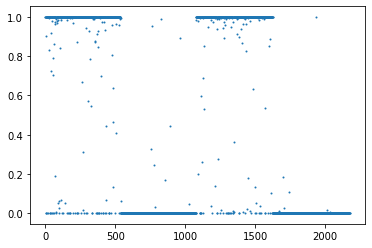

In [43]:
matplotlib.pyplot.close("all")
matplotlib.pyplot.scatter([x for x in range(len(TestData))], TestData["Predictions"], s = 1)

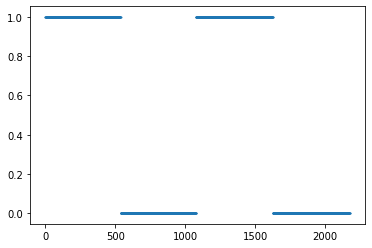

In [44]:
matplotlib.pyplot.close("all")
matplotlib.pyplot.scatter([x for x in range(len(TestData))], TestData["has_oilpalm"], s = 1)